# 02 Keras - the sequential model

Implementing a neural network in pure Theano or TensorFlow is, let us be honest, far from trivial, especially if you're not a computer scientist with a decent background in math and calculus. Building your own networks from scratch therefore tends to be time-consuming and error-prone. Luckily there are a number of excellent libraries, such as **Keras** (http://keras.io/), a highly popular and user-friendly Deep Learning library, that functions as a wrapper around Theano or TensorFlow, which it uses as its **backend**. In this chapter, we will learn how to set up a basic experiment in keras, using its **Sequential** model. We set up our environment first:

In [3]:
from __future__ import print_function

import os
import codecs

import matplotlib.pyplot as plt

%matplotlib inline

import numpy as np

## The (Multilayer) Perceptron

Let us start off with an easy task and build a (multi-layer) perceptron that is optimized to perform topic classification on text documents: we will build a neural network on top of a simple bag-of-words model. I provided some training from the 20 newsgroups data set in the repository under `data/newsgroups`:

In [4]:
path = 'data/newsgroups/'
for dir_name in os.listdir(path):
    if os.path.isdir(path+dir_name):
        cnt = 0
        for fn in os.listdir(path+dir_name):
            cnt += 1
        print(dir_name, '->', cnt, 'files')

alt.atheism -> 1000 files
rec.autos -> 1000 files
rec.sport.baseball -> 1000 files
sci.med -> 1000 files
talk.politics.mideast -> 1000 files


As you can see, we have ca. 5000 documents distributed over five topical categories, raning from cars to politics. Training a document classifier on this data should be fairly straightforward, because of the huge thematic differences we can expect in the texts' vocabularies. We can read in the documents and labels as follows:

In [5]:
documents, labels = [], []
for dir_name in os.listdir(path):
    if os.path.isdir(path+dir_name):
        for fn in os.listdir(path+dir_name):
            with codecs.open(path+dir_name+'/'+fn, 'r', 'utf8') as f:
                try:
                    text = f.read()
                    documents.append(text)
                    labels.append(dir_name)
                except UnicodeDecodeError:
                    pass

print('# documents:', len(documents))
print('# labels:', len(labels))

# documents: 4979
# labels: 4979


As you can see, encoding issues prevented us from loading a couple of files, but that's OK for this dummy case study. The variable `documents` now holds a list of strings: to convert these into a standard bag-of-words model, we can use the efficient `TfidfVectorizer` from `sklearn`:

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

Let us fit and apply the vectorizer to our documents, but let's not use TF-IDF rescoring or remove stop words (in order not to make the problem too easy either).

In [7]:
vectorizer = TfidfVectorizer(max_features=5000, analyzer='word', use_idf=False)
X = vectorizer.fit_transform(documents).toarray()
print(X.shape)

(4979, 5000)


We obtain a 4979 by 5000 matrix: 4979 row vectors in which each documented is characterized by 5000 relative word frequencies. Let us have a look at some of the vocabulary items included:

In [8]:
print(vectorizer.get_feature_names()[1000:1100])

[u'clarku', u'clas', u'class', u'classic', u'clean', u'cleaning', u'cleansing', u'clear', u'clearly', u'clemens', u'cleveland', u'clinic', u'clinical', u'clinton', u'clock', u'close', u'closed', u'closely', u'closer', u'clothes', u'club', u'clutch', u'cma', u'cmu', u'cnsvax', u'co', u'coat', u'cobb', u'cobra', u'code', u'coe', u'col', u'cold', u'collaboration', u'collection', u'college', u'color', u'colorado', u'colostate', u'columbia', u'columbiasc', u'com', u'combined', u'come', u'comes', u'comfortable', u'coming', u'comm', u'command', u'commander', u'comment', u'comments', u'commercial', u'commit', u'committed', u'committee', u'common', u'commonly', u'communication', u'communications', u'communist', u'communities', u'community', u'comp', u'companies', u'company', u'compaq', u'comparable', u'compare', u'compared', u'comparing', u'comparison', u'compartment', u'competition', u'complain', u'complaints', u'complete', u'completely', u'complex', u'comprehensive', u'compromise', u'computer

That looks OK. Now, we still need to preprocess our labels, which we only have as strings right now. Again, `scikit` to the rescue!

In [10]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(labels)
print(y.shape)
print(y[:10])
print(y[-10:])

(4979,)
[0 0 0 0 0 0 0 0 0 0]
[4 4 4 4 4 4 4 4 4 4]


Our document labels are now neatly encoded as integers, rather than strings. One problem remains: in the previous chapter we could use a fairly simple loss measure for the regression problem we were trying to solve, which operated on the basis of two vectors of floats. Our neural network for classification, however, outputs a probability distribution over class labels, rather than a list of class integers. We will therefore need a different loss function. The **cross-entropy loss** (or [log loss](https://en.wikipedia.org/wiki/Cross_entropy)) is a much more common objective function in neural networks: it will compare how far the probability distribution outputted by our model is from the ideal result. Therefore, we will have to convert our gold standard integer labels to probability vectors too: these will be **one-hot vectors** or vectors in which a single item is equal to 1 (at the position of the correct class) and all others are set to zero. Luckily, this conversion is easy enough to implement if you where to look for the right functions:

In [14]:
from keras.utils import np_utils
Y = np_utils.to_categorical(y)

As you can see, our list of integer labels has been neatly converted to a one-hot representation, where the ones indicate the correct classes. Each class in our classification experiment corresponds to a column in this matrix:

In [15]:
print(Y.shape)
print(Y[:5])
print(Y[-5:])

(4979, 5)
[[ 1.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.]]
[[ 0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  1.]]


We are almost there: the good experimental practice in Deep Learning is the same as elsewhere in Machine Learning: we should divide the available data in a **training, development and test set**. We optimize our model using the training data, while monitoring it performance on the development data. After we have determined the model parameters that performed best on the train and dev set, we evaluate it on the test set. Again, this splitting procedure is trivial to achieve using `scikit`:

In [16]:
from sklearn.cross_validation import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y,
                    test_size=0.10, random_state=42982)

X_train, X_dev, Y_train, Y_dev = train_test_split(X_train, Y_train,
                     test_size=0.10, random_state=476710)

print('Train data:', X_train.shape)
print('Dev data:', X_dev.shape)
print('Test data:', X_test.shape)

Train data: (4032, 5000)
Dev data: (449, 5000)
Test data: (498, 5000)


Now, we are ready to start building our network in keras, which has support for two model types: the `Sequential` model and the (functional) Model. We will start with the former because it is the easiest: the `Sequential` model assumes that we will building a fairly straightforward model, that is a stack of consecutive layers that are fed into one another. We need to initialize the model before we can start adding layers to it:

In [23]:
from keras.models import Sequential

model = Sequential()

The **Logistic Regression** model implemented below is the simplest neural network you can imagine: it has a single `Dense` layer which represents a **dot product** followed by a **bias** addition. As its final activation, we include a **`softmax` normalization**, we will ensure that our predictions for each classes sum to one per instance. Note that the only information we should include is the number of features in our document vector matrix (i.e. 5000) as well as the number of output classes (i.e. 5). Keras needs this information of course to be able to initialize a weight matrix and bias vector that have the correct shape:

In [24]:
from keras.layers.core import Dense

nb_classes = Y.shape[1]
nb_features = X.shape[1]

model.add(Dense(nb_classes, input_dim=nb_features, activation='softmax'))

This is equivalent to the following, where we add the softmax activation as a separate layer:

In [25]:
from keras.layers.core import Activation

model = Sequential()
model.add(Dense(nb_classes, input_dim=nb_features))
model.add(Activation('softmax'))

Inspecting what your model looks like after you have constructed is often useful for debugging purposes:

In [26]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                       Output Shape        Param #     Connected to                     
dense_6 (Dense)                    (None, 5)           25005       dense_input_5[0][0]              
____________________________________________________________________________________________________
activation_2 (Activation)          (None, 5)           0           dense_6[0][0]                    
Total params: 25005
____________________________________________________________________________________________________


Naming your layers might also be helpful in this respect:

In [29]:
from keras.layers.core import Activation

model = Sequential()
model.add(Dense(nb_classes, input_dim=nb_features, name='dense1'))
model.add(Activation('softmax', name='softmax1'))
model.summary()

____________________________________________________________________________________________________
Layer (type)                       Output Shape        Param #     Connected to                     
dense1 (Dense)                     (None, 5)           25005       dense_input_7[0][0]              
____________________________________________________________________________________________________
softmax1 (Activation)              (None, 5)           0           dense1[0][0]                     
Total params: 25005
____________________________________________________________________________________________________


Under the hood, what we have constructed is in reality a fairly simple Theano (default) or Tensorflow **graph** that still needs to be **compiled** for it to become useful. In the following block, we compile our training function, and we specify that we would like to optimize the parameters of our model using **stochastic gradient descent** (`sgd`), in order to minimize the `categorical_crossentropy` loss measure.

In [30]:
model.compile(optimizer='sgd', loss='categorical_crossentropy')

As with hardcore theano functions, you might have noticed a small time lapse during compilation, which is perfectly normal. We are now ready to `fit()` our model on the training data. In the code below, we start a fitting procedure that will last for 25 **epochs**: it will loop over the entire data for 25 times, using minibatch with a size of 50 items.

In [31]:
model.fit(X_train, Y_train, batch_size=50, nb_epoch=25)

Epoch 1/25
4032/4032 [==============================] - 0s - loss: 1.6066     
Epoch 2/25
4032/4032 [==============================] - 0s - loss: 1.6025     
Epoch 3/25
4032/4032 [==============================] - 0s - loss: 1.5986     
Epoch 4/25
4032/4032 [==============================] - 0s - loss: 1.5947     
Epoch 5/25
4032/4032 [==============================] - 0s - loss: 1.5908     
Epoch 6/25
4032/4032 [==============================] - 0s - loss: 1.5870     
Epoch 7/25
4032/4032 [==============================] - 0s - loss: 1.5832     
Epoch 8/25
4032/4032 [==============================] - 0s - loss: 1.5794     
Epoch 9/25
4032/4032 [==============================] - 0s - loss: 1.5757     
Epoch 10/25
4032/4032 [==============================] - 0s - loss: 1.5719     
Epoch 11/25
4032/4032 [==============================] - 0s - loss: 1.5683     
Epoch 12/25
4032/4032 [==============================] - 0s - loss: 1.5646     
Epoch 13/25
4032/4032 [==========================

Apart from Keras's great **progress bar** -- showing you the number of training items processed, you can also monitor the *average per-batch cross-entropy loss*. As you can see, the gradient descent algorithm gently steers the model down the loss surface of our model. It is also possible to monitor additional per-batch metrics, such as plain **accuracy**, by specifying this when re-compiling the model:

In [32]:
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, Y_train, batch_size=50, nb_epoch=25)

Epoch 1/25
4032/4032 [==============================] - 0s - loss: 1.5153 - acc: 0.6711     
Epoch 2/25
4032/4032 [==============================] - 0s - loss: 1.5119 - acc: 0.6744     
Epoch 3/25
4032/4032 [==============================] - 0s - loss: 1.5086 - acc: 0.6756     
Epoch 4/25
4032/4032 [==============================] - 0s - loss: 1.5052 - acc: 0.6848     
Epoch 5/25
4032/4032 [==============================] - 0s - loss: 1.5019 - acc: 0.6818     
Epoch 6/25
4032/4032 [==============================] - 0s - loss: 1.4986 - acc: 0.6873     
Epoch 7/25
4032/4032 [==============================] - 0s - loss: 1.4953 - acc: 0.6922     
Epoch 8/25
4032/4032 [==============================] - 0s - loss: 1.4920 - acc: 0.6927     
Epoch 9/25
4032/4032 [==============================] - 0s - loss: 1.4888 - acc: 0.6949     
Epoch 10/25
4032/4032 [==============================] - 0s - loss: 1.4855 - acc: 0.6954     
Epoch 11/25
4032/4032 [==============================] - 0s - loss: 1

During training, it is also possible to monitor the model's performance on the development data. We can simply include in the fitting process as follows:

In [34]:
model.fit(X_train, Y_train, batch_size=50, nb_epoch=25, validation_data=(X_dev, Y_dev))

Train on 4032 samples, validate on 449 samples
Epoch 1/25
4032/4032 [==============================] - 0s - loss: 1.3654 - acc: 0.7587 - val_loss: 1.3717 - val_acc: 0.7795
Epoch 2/25
4032/4032 [==============================] - 0s - loss: 1.3628 - acc: 0.7612 - val_loss: 1.3692 - val_acc: 0.7795
Epoch 3/25
4032/4032 [==============================] - 0s - loss: 1.3601 - acc: 0.7584 - val_loss: 1.3666 - val_acc: 0.7817
Epoch 4/25
4032/4032 [==============================] - 0s - loss: 1.3574 - acc: 0.7612 - val_loss: 1.3640 - val_acc: 0.7817
Epoch 5/25
4032/4032 [==============================] - 0s - loss: 1.3548 - acc: 0.7619 - val_loss: 1.3614 - val_acc: 0.7840
Epoch 6/25
4032/4032 [==============================] - 0s - loss: 1.3522 - acc: 0.7644 - val_loss: 1.3588 - val_acc: 0.7840
Epoch 7/25
4032/4032 [==============================] - 0s - loss: 1.3496 - acc: 0.7646 - val_loss: 1.3563 - val_acc: 0.7840
Epoch 8/25
4032/4032 [==============================] - 0s - loss: 1.3470 - ac

Note that in the previous code block, we did not start fitting an entirely new model: rather we kept on training with the weights for the previous call to `fit()`. **Model persistence** is neatly supported in keras too. To save/load a model you need two things: (a) an abstract description of what your model looks like (i.e., the **model architecture**, which can be saved/loaded as `json`) and (b) the optimized weights that go with your model layers (stored in the well-known HDF5 format). Saving our model is as easy as:

In [35]:
json_string = model.to_json()
open('my_model_architecture.json', 'w').write(json_string)
model.save_weights('my_model_weights.h5', overwrite=True)

Loading the model again later goes something like:

In [36]:
from keras.models import model_from_json
model = model_from_json(open('my_model_architecture.json').read())
model.load_weights('my_model_weights.h5')

Using our reloaded model again, to get predictions for our test data can be done as follows:

In [40]:
preds = model.predict(X_test)
print(preds.shape)

(498, 5)


Note that, unlike other Machine Learning libraries, the `predict()` method returns the output of model (i.e. probability vectors) instead of actual class labels. This in fact equivalent to:

In [41]:
probas = model.predict_proba(X_test)
print(probas[:10]) 

498/498 [==============================] - 0s     
[[ 0.21541086  0.20062955  0.1952868   0.16446635  0.22420645]
 [ 0.15213951  0.28768435  0.21805581  0.19468707  0.14743324]
 [ 0.18644069  0.20904589  0.30216891  0.18888345  0.11346107]
 [ 0.190134    0.21612746  0.24849096  0.19813235  0.14711525]
 [ 0.27884284  0.20661949  0.17659087  0.18714631  0.15080051]
 [ 0.1566499   0.25290233  0.22340366  0.25574687  0.11129723]
 [ 0.24600069  0.17016095  0.17942293  0.19304174  0.21137369]
 [ 0.26545805  0.15187761  0.1461696   0.18621506  0.25027969]
 [ 0.15660031  0.22786793  0.24914759  0.20878647  0.15759769]
 [ 0.23474878  0.15574567  0.13212231  0.18832782  0.28905544]]


See how each row sums to one? To obtain the actual class labels predicted (or rather: the integers that represent them), you can use this method:

In [42]:
preds = model.predict_classes(X_test)
print(preds[:10])

498/498 [==============================] - 0s     
[4 1 2 2 0 3 0 0 2 4]


Therefore, `predict()` should not be confused with `predict_classes()`. What `predict_classes` does under the hood, is in fact returning the column index of the class with the highest probability in each prediction vector. In `numpy` speak:

In [43]:
preds = model.predict(X_test)
class_ints = preds.argmax(axis=1)
print(class_ints[:10])

[4 1 2 2 0 3 0 0 2 4]


To see which classes have been predicted, we can use our label encoder to reverse engineering the integer encoding:

In [44]:
predicted_classes = label_encoder.inverse_transform(class_ints)
correct_classes = label_encoder.inverse_transform(Y_test.argmax(axis=1))
for i, j in zip(predicted_classes, correct_classes)[:10]:
    print(i, '->', j)

talk.politics.mideast -> talk.politics.mideast
rec.autos -> rec.autos
rec.sport.baseball -> rec.sport.baseball
rec.sport.baseball -> talk.politics.mideast
alt.atheism -> alt.atheism
sci.med -> sci.med
alt.atheism -> talk.politics.mideast
alt.atheism -> alt.atheism
rec.sport.baseball -> rec.sport.baseball
talk.politics.mideast -> talk.politics.mideast


How well are we doing so far? Let's find out:

In [45]:
from sklearn.metrics import accuracy_score
print('Test accuracy:', accuracy_score(predicted_classes, correct_classes))

Test accuracy: 0.789156626506


Wow! We should be able to do much better. One thing people commonly do is make their networks deeper, i.e.t they stack multiple `Dense` layers on top of each other, hoping to learn better representations as the tensors flow through deeper layers in the network. Using keras, stacking layers is trivial; the only thing we need to take special care of are the dimensionality of the very first and very last layer, because there, keras needs the know the correct number of input features and output classes respectively. Except for the last layer (the dimensionality of which is controlled by the number of output classes), all other layers have a dimensionality of `nb_dim` in this example:

In [46]:
model = Sequential()

nb_layers = 5
nb_dim = 100

for l in range(nb_layers):
    if l == 0:
        model.add(Dense(nb_dim, input_dim=nb_features, activation='sigmoid'))
    if l < (nb_layers - 1):
        model.add(Dense(nb_dim, input_dim=nb_dim, activation='sigmoid'))
    else:
        model.add(Dense(nb_classes, input_dim=nb_dim, activation='softmax'))


In [47]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                       Output Shape        Param #     Connected to                     
dense_8 (Dense)                    (None, 100)         500100      dense_input_9[0][0]              
____________________________________________________________________________________________________
dense_9 (Dense)                    (None, 100)         10100       dense_8[0][0]                    
____________________________________________________________________________________________________
dense_10 (Dense)                   (None, 100)         10100       dense_9[0][0]                    
____________________________________________________________________________________________________
dense_11 (Dense)                   (None, 100)         10100       dense_10[0][0]                   
___________________________________________________________________________________________

As you can see, we add a sigmoidal layer as an activation after each dense layer: because the sigmoid squashes the result of a dense layer between 0-1, this will avoid the phenomen of exploding weights. This already a much more complex model, with several K's of parameters that have to be adjusted with each update. Unsurprisingly, such models take much longer to train, although they are often found to learn better features.

In [49]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, Y_train, batch_size=50, nb_epoch=25, validation_data=(X_dev, Y_dev))

Train on 4032 samples, validate on 449 samples
Epoch 1/25
4032/4032 [==============================] - 0s - loss: 1.6225 - acc: 0.2061 - val_loss: 1.6093 - val_acc: 0.1826
Epoch 2/25
4032/4032 [==============================] - 0s - loss: 1.6175 - acc: 0.1964 - val_loss: 1.6101 - val_acc: 0.2138
Epoch 3/25
4032/4032 [==============================] - 0s - loss: 1.6017 - acc: 0.2254 - val_loss: 1.5578 - val_acc: 0.4543
Epoch 4/25
4032/4032 [==============================] - 0s - loss: 1.3130 - acc: 0.4995 - val_loss: 1.1026 - val_acc: 0.4900
Epoch 5/25
4032/4032 [==============================] - 0s - loss: 0.9042 - acc: 0.6652 - val_loss: 0.7827 - val_acc: 0.7261
Epoch 6/25
4032/4032 [==============================] - 0s - loss: 0.5701 - acc: 0.8514 - val_loss: 0.5805 - val_acc: 0.8107
Epoch 7/25
4032/4032 [==============================] - 0s - loss: 0.3034 - acc: 0.9395 - val_loss: 0.2986 - val_acc: 0.9065
Epoch 8/25
4032/4032 [==============================] - 0s - loss: 0.1729 - ac

As you can see, the model has become so deep, that is is extremely slow to **converge** using traditional SGD. Interestingly, people have developed many other optimizers that can often speed up convergence. These optimizers (`adam, adadelta, rmsprop, ...`) are all loosely based on the conventional idea behind 'traditional' SGD but they keep track of the (recent) gradient history: if a button has been turned down a lot in the recent past, these 'fast learners' will stimulate that gradient direction in the future.

### DIY

Experiment with the following parameters in our MLP (**Multi-Layer Perceptron**):
* The number of layers
* The dimensionality of the **hidden layers**
* The batch size
* The optimizer

Especially the optimizer can have a huge beneficial effect in this particular case. The same goes for preprocessing: look at what happens when you remove English stopwords from the sklearn vectorizer and allow TF-IDF weighting. Impressive, no?

## Representation learning

As we all know, "Deep Learning" is but a **hipster term** for multi-layered neural networks. The real power from this modelling approach is that it automatically *learns how to best represent the input data, alleviating to a considerable extent the need for manual feature engineering*. Therefore, **Representation Learning** is in fact a much better, and more neutral description of the kind of Machine Learning that is being studied in this field. But what *are* the representations learned at the various layers in our network? Interestingly, keras makes it relatively easy for us to find this out. Remember that our keras model is in fact nothing more than a wrapper around a Theano or TensorFlow graph. That means that we can simply select an intermediary layer in our network, and compile a function which gives us the computational steps which the data undergoes up until there. 

In [50]:
from keras import backend as K

last_dense_activation = K.function([model.layers[0].input], # 0 -> indicates predict-phase, instead of training phase
                                  [model.layers[4].output]) # fourth dense layer in our network

We can now simply run our (unseen!) test data through this newly compiled function to obtain the representation of the data at this stage:

In [51]:
layer_output = last_dense_activation([X_test])[0]
print(layer_output.shape)

(498, 100)


As expected we obtain a 100-dimensional representation of our data, i.e. the activations of the neurons on one of the 'dark' layers. A great way to inspect what has been learned so far is to visualize the instances on the basis of this activation. First, we normalize the representations to unit norm:

In [52]:
from keras.utils import np_utils

norm_weights = np_utils.normalize(layer_output)
print(norm_weights.shape)

(498, 100)


As expected, this normalization operation didn't change the shape of our matrix. We can now run the [t-SNE](https://lvdmaaten.github.io/tsne/) ('t-Stochastic Neighbor Embedding', pronounced *teesnee*) algorithm on this data, a highly popular technique in the DL community to visualize high-dimensional data in a two-dimensional scatterplot, neatly showing the main structure in the data. Since a while, t-SNE has bene added to `scikit`:

In [53]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
coor = tsne.fit_transform(norm_weights)

In the following code block, we visualize this data, and add some color:

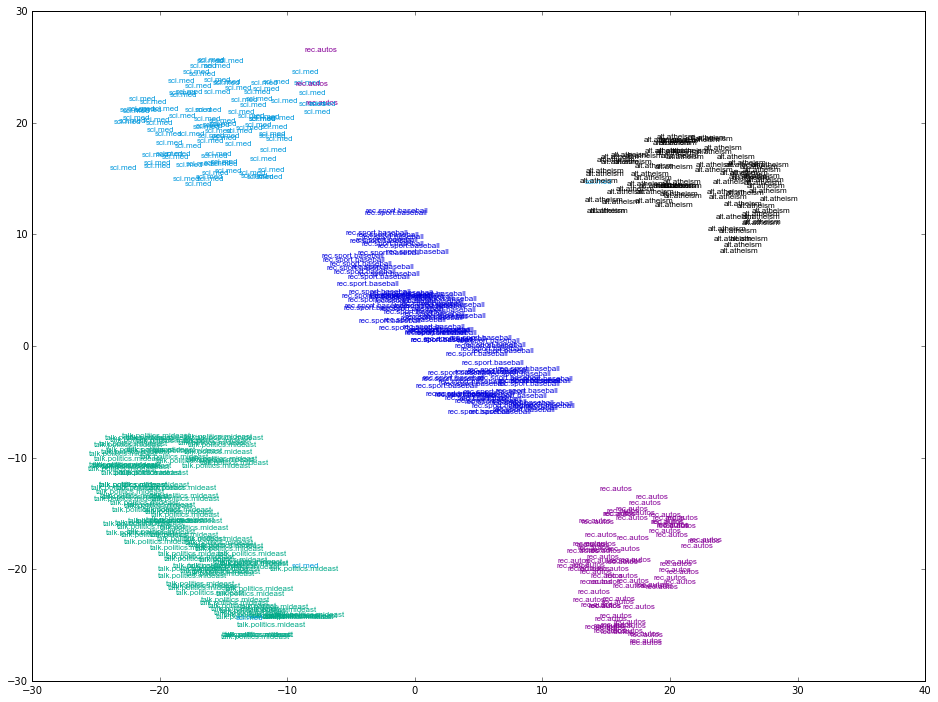

In [59]:
fig, ax1 = plt.subplots(figsize=(16, 12))  
test_ints = Y_test.argmax(axis=1)
test_classes = label_encoder.inverse_transform(test_ints)

x1, x2 = coor[:,0], coor[:,1]
ax1.scatter(x1, x2, 100, edgecolors='none', facecolors='none')

for x, y, name_int, name_label in zip(x1, x2, test_ints, test_classes):
    ax1.text(x, y, name_label, ha='center', va="center",
            color=plt.cm.spectral(name_int / 10.),
            fontdict={'family': 'Arial', 'size': 8})
plt.show()

Visualizing such representations are a great way to inspect and intuitively evaluate your work.

## Embeddings

Among the linguistic members of the Deep Learning community, a great deal of attention is currently paid to word embeddings, especially in the field of distributional semantics, where scholars to cheaply obtain good representations of the meaning of words. Keras has an **Embedding** which comes in very handy to model word meanings in this respect. In Natural Language Processing (NLP), scholars have to work with sparsely populated vectors. In the context of Part of Speech (POS) tagging, for instance, we crucially depend on contextual information about the words surrounding the word which we are trying to disambiguate. Commonly, researchers will inspect the two words immediately before, and one word after after a particular **focus token** to model the **lexical** context in which a token occurs. Represnting such words is commonly done using a type of **one-hot vector** that is reminiscent of the output format for the softmax layer which we used above. We assign a unique index to each word in the corpus vocabulary and represent each word as a long vector with a position for each vocabulary item. All entries are set to zero, except for the target index, which is set to one, leading to the one-hot representation.

We can simpy feed a one-hot vector to a dense layer in Keras, but that is in fact a huge of waste of computational resources: all entries, except the hot target entry, are equal to zero and will not contribute anything to the dot product. From a computational perspective, this operation is in fact equal equivalent to simply **selecting the single relevant vector from our weight matrix**, instead of wasting huge resources on a full dot product. And that is exactly what the Embedding layer can do for us. In this section, we will use embeddings in a simple, but fully functional POS tagging model implemented in keras. For this application, I have included the train and test data from the (CoNLL-2000 shared task)[http://www.cnts.ua.ac.be/conll2000/chunking/] on POS tagging and chunking, under `data/seq`. You can load it as follows:

In [61]:
def load_data(path):
    data = []
    for line in codecs.open(path, 'r', 'utf8'):
        line = line.strip()
        if line:
            try:
                token, pos, _ = line.strip().split()
                data.append((token, pos))
            except:
                pass
    return data

        
train_data = load_data('data/seq/train.txt')
test_data = load_data('data/seq/test.txt')

print(len(train_data))
for i in train_data[:10]:
    print(' - '.join(i))

211727
Confidence - NN
in - IN
the - DT
pound - NN
is - VBZ
widely - RB
expected - VBN
to - TO
take - VB
another - DT


In [66]:
train_tokens, train_pos = zip(*train_data)
test_tokens, test_pos = zip(*test_data)

First, we need to convert our POS labels into the correct one-hot format. You should be familiar with this operation by now:

In [67]:
tag_encoder = LabelEncoder()
tag_encoder.fit(train_pos)
print('Total nb POS tags:', len(tag_encoder.classes_))

train_y = tag_encoder.transform(train_pos)
test_y = tag_encoder.transform(test_pos)

Y_train = np_utils.to_categorical(train_y,
                                  nb_classes=len(tag_encoder.classes_))
Y_test = np_utils.to_categorical(test_y,
                                 nb_classes=len(tag_encoder.classes_))


Total nb POS tags: 44


For our embeddings, we now first create a vocabulary index, taking the form of a Python dictionary which holds for each unique word a unique integer. We explicitly reserve the index of `0` for out-of-vocabulary items, as you will see:

In [68]:
from collections import Counter
vocab = Counter(train_tokens)

indexer = {'unk': 0}
for k, v in vocab.most_common():
    indexer[k] = len(indexer)

We are now ready to vectorize our data. For each focus token in the data (at index `n`), we extract the sequence of words, starting at `n-2`, up until n+1; i.e. including the focus. We represent this sequence of words as a sequence of integers corresponding to our `indexer`.

In [69]:
nb_left, nb_right = 2, 1

def vectorize(tokens):
    sequences = []
    for curr_idx, token in enumerate(tokens):
        left_context = tokens[(curr_idx - 2) : curr_idx]
        while len(left_context) < nb_left:
            left_context = ['<unk>'] + left_context # pad, if necessary

        right_context = tokens[curr_idx + 1 : curr_idx + 2]
        while len(right_context) < nb_right:
            right_context += ['<unk>'] # pad, if necessary

        seq = left_context + [token] + right_context

        ints = [indexer[t] if t in indexer else 0 for t in seq]

        sequences.append(ints)
    
    return np.array(sequences, dtype='int8')

train_X = vectorize(list(train_tokens))
test_X = vectorize(list(test_tokens))

We are now ready to define our model. Again, this is surprisingly easy. Our first layer is the new embeddings layer: using the four integers in each instance, it will select a matrix of four vectors (each consisting of 150 neurons), corresponding to the relevant vectors from the embeddings weight matrix. Note that using the parameters of the `Embedding()`, we have to specify the number of neurons we would like to have per word in our weight matrix, the length of the sequences (i.e. 4), and the size of our vocabulary. After that, we use the `Flatten()` layer to convert our 4 x 150 embeddings to a single, flat vector of 600 values. Then, we add a sigmoidal activation. It is on top of this layer that we finally stack our dense layer, which will predict the probabilities of our tag labels:

In [70]:
from keras.layers import Embedding, Dense, Activation, Flatten

model = Sequential()
model.add(Embedding(input_dim=len(indexer), output_dim=150,
                    input_length=nb_left + 1 + nb_right))
model.add(Flatten())
model.add(Activation('sigmoid'))
model.add(Dense(len(tag_encoder.classes_)))
model.add(Activation('softmax'))

Next, we compile and fit the model like we did before:

In [71]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(train_X, Y_train, batch_size=100, nb_epoch=10,
          shuffle=True, validation_data=(test_X, Y_test))

Train on 211727 samples, validate on 47377 samples
Epoch 1/10
211727/211727 [==============================] - 53s - loss: 1.9101 - acc: 0.4853 - val_loss: 1.2507 - val_acc: 0.6511
Epoch 2/10
211727/211727 [==============================] - 54s - loss: 1.1176 - acc: 0.6770 - val_loss: 1.0625 - val_acc: 0.6812
Epoch 3/10
211727/211727 [==============================] - 53s - loss: 1.0059 - acc: 0.6986 - val_loss: 1.0277 - val_acc: 0.6925
Epoch 4/10
 59900/211727 [=======>......................] - ETA: 38s - loss: 0.9704 - acc: 0.7071

KeyboardInterrupt: 

As you can see, this is a pretty heavy model to train, which is probably related to the considerable number of parameters it contains:

In [72]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                       Output Shape        Param #     Connected to                     
embedding_1 (Embedding)            (None, 4, 150)      2868450     embedding_input_1[0][0]          
____________________________________________________________________________________________________
flatten_1 (Flatten)                (None, 600)         0           embedding_1[0][0]                
____________________________________________________________________________________________________
activation_3 (Activation)          (None, 600)         0           flatten_1[0][0]                  
____________________________________________________________________________________________________
dense_14 (Dense)                   (None, 44)          26444       activation_3[0][0]               
___________________________________________________________________________________________

Our part-of-speech tagger isn't exactly state of the art yet, and the training accuracy seems to saturate around 70% (which is an unacceptably bad result for such an easy task). In the next chapter, we will use some of the bells and whistles in keras to get our model up to speed. One final remark is that the embedding layer itself in keras is essentially unrelated to the kind of word embeddings trained with popular models such as [word2vec](https://en.wikipedia.org/wiki/Word2vec). One thing which I often find myself doing is pretraining word embeddings on a large unannotated corpus using the (awesome!) `word2vec` implementation in the [Gensim](https://radimrehurek.com/gensim/models/word2vec.html) package. Next, it is trivial to initialize the parameters of the embedding layer in keras using the embeddings matrix obtained from the pretrained `word2vec` model, which often significantly speeds up convergence.

----------------------------------------